In [7]:
import string
import re
import os
import math
import pickle
import copy
import random
import bz2
import numpy
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter
from tqdm import tqdm
lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer 
ps = PorterStemmer()
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

### Loading the required pickle files

In [8]:
Picklefile2 = open('files_list', 'rb')
files = pickle.load(Picklefile2)

Picklefile3 = open('dictionary_doc_mapping', 'rb')
dict_folder_doc_mapping = pickle.load(Picklefile3)

Picklefile4 = open('dictionary_master', 'rb')
mstr_dict_dict = pickle.load(Picklefile4)

Picklefile8 = bz2.open('list_dictionary_tfidf_vectors', 'rb')
list_dict_vectors_tfidf = pickle.load(Picklefile8)

Picklefile9 = bz2.open('list_dictionary_mi_vectors', 'rb')
list_dict_vectors_mi = pickle.load(Picklefile9)

Picklefile10 = open('list_list_training_documents', 'rb')
list_list_train_docs = pickle.load(Picklefile10)

Picklefile11 = open('list_list_testing_documents', 'rb')
list_list_test_docs = pickle.load(Picklefile11)

In [9]:
count_total_docs = len(mstr_dict_dict)
list_all_doc_ids = list(mstr_dict_dict.keys())

### Defining the function to apply KNN classifier on the testing documents and assigning them to a class

In [10]:
def apply_KNN(value_k, dict_doc_vectors, list_train_docs, list_test_docs):
    global dict_predicted_class
    dict_predicted_class = {}
    
    for p in list_test_docs:
        #Finding cosine similarity of the testing doc with each training doc
        np_test_vector = numpy.array(dict_doc_vectors[p])
        norm_value_test = numpy.linalg.norm(np_test_vector)
        list_cosine_sim_pairs = []
        for q in list_train_docs:
            np_train_vector = numpy.array(dict_doc_vectors[q])
            norm_value_train = numpy.linalg.norm(np_train_vector)
            value_cosine_sim = (numpy.dot(np_test_vector, np_train_vector)) / (norm_value_test * norm_value_train)
            list_cosine_sim_pairs.append([q, value_cosine_sim])
        
        #Now finding the k nearest neighbours
        list_cosine_sim_pairs.sort(key=lambda x:x[1], reverse=True)
        #Making a list of the k-nearest neighbours
        list_knn = [z[0] for z in list_cosine_sim_pairs[:value_k+1]]
        #Getting the list of classes of the k neighbours
        list_neighbours_class = [dict_folder_doc_mapping[u] for u in list_knn]
        #Finding the majority class among the k-nearest neighbours
        counter_neigh_class = Counter(list_neighbours_class)
        list_pairs_class_counts = [[g, counter_neigh_class[g]] for g in counter_neigh_class]
        list_pairs_class_counts.sort(key=lambda x:x[1], reverse=True)
        #Assigning the majority class to the test document
        dict_predicted_class[p] = list_pairs_class_counts[0][0]
        

### Defining the function to print the confusion matrix and accuracy.

In [11]:
def confusion_matrix_accuracy():
    list_labels_actual = []
    list_labels_predicted = []
    global value_accuracy
    #Preparing lists of class assigned and the actual class of the testing documents
    for o in dict_predicted_class:
        list_labels_actual.append(dict_folder_doc_mapping[o])
        list_labels_predicted.append(dict_predicted_class[o])
        
    print("The confusion matrix is:")
    print(confusion_matrix(list_labels_actual, list_labels_predicted))
    print("The accuracy score is:")
    value_accuracy = accuracy_score(list_labels_actual, list_labels_predicted)
    print(value_accuracy)

### Calling the functions defined above for different split ratios and different vlaues of k in KNN

In [12]:
list_splits = [[50, 50],[70, 30],[80, 20]]

list_accuracy_tfidf = []
list_acccuracy_mi = []

for s in range(len(list_splits)):
    list_docs_train = list_list_train_docs[s]
    list_docs_test = list_list_test_docs[s]
        
    for count_k in range(1,7,+2):
        dict_vectors = list_dict_vectors_tfidf[s]
        apply_KNN(count_k, dict_vectors, list_docs_train, list_docs_test)
        print(f"\nFor {list_splits[s][0]}:{list_splits[s][1]} split and k = {count_k} using tf-idf features :")
        confusion_matrix_accuracy()
        list_accuracy_tfidf.append([count_k, value_accuracy])
        
        dict_vectors = list_dict_vectors_mi[s]
        apply_KNN(count_k, dict_vectors, list_docs_train, list_docs_test)
        print(f"\nFor {list_splits[s][0]}:{list_splits[s][1]} split and k = {count_k} using mutual independence features :")
        confusion_matrix_accuracy()
        list_acccuracy_mi.append([count_k, value_accuracy])


For 50:50 split and k = 1 using tf-idf features :
The confusion matrix is:
[[252   1 233  13   3]
 [  0 301 208   0   3]
 [  2   1 476   4  13]
 [  1   0 147 325  16]
 [  2   4 128   6 361]]
The accuracy score is:
0.686

For 50:50 split and k = 1 using mutual independence features :
The confusion matrix is:
[[300   4 174   8  16]
 [  0 137  90   0 285]
 [  2   3 427  13  51]
 [  0   3  79 265 142]
 [  7   5 105  10 374]]
The accuracy score is:
0.6012

For 50:50 split and k = 3 using tf-idf features :
The confusion matrix is:
[[251   1 233  14   3]
 [  0 298 209   0   5]
 [  1   0 477   6  12]
 [  1   0 151 323  14]
 [  2   4 130   5 360]]
The accuracy score is:
0.6836

For 50:50 split and k = 3 using mutual independence features :
The confusion matrix is:
[[297   4 169  16  16]
 [  0 345  96   1  70]
 [  2   3 450  12  29]
 [  0   8  70 378  33]
 [  7   8 120   9 357]]
The accuracy score is:
0.7308

For 50:50 split and k = 5 using tf-idf features :
The confusion matrix is:
[[188   0 2

### Plotting a graph of k-value vs accuracy obtained for 70:30 split size

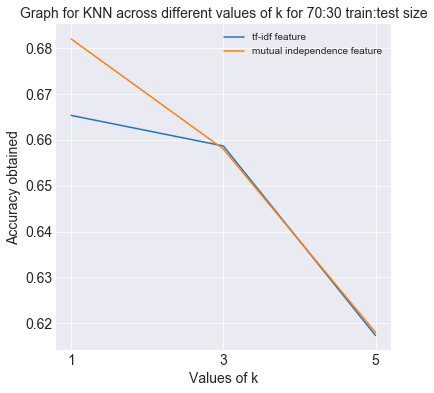

In [23]:
list_cord_x = ['1', '3', '5']
list_tfidf_acc = [list_accuracy_tfidf[i][1] for i in range(3,6)]
list_mi_acc = [0.682, 0.658, 0.618]
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(6,6))
plt.plot(list_cord_x, list_tfidf_acc, label = 'tf-idf feature')
plt.plot(list_cord_x, list_mi_acc, label = 'mutual independence feature' )
plt.xlabel('Values of k', fontsize = 14)
plt.ylabel('Accuracy obtained', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(label = 'Graph for KNN across different values of k for 70:30 train:test size', fontsize = 14)
plt.legend()
plt.show()
        

In [24]:
Picklefile12 = open('list_accuracies tfidf', 'wb')
pickle.dump(list_accuracy_tfidf, Picklefile12)
Picklefile12.close()

### Plotting the graph for different split ratios vs. the accuracy obtained for k = 3

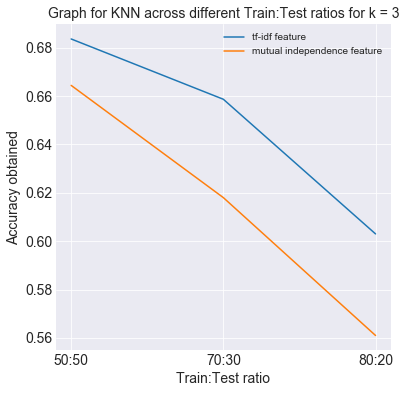

In [25]:
#Now plotting graph across different train:test ratios for k=5
list_cord_x = ['50:50', '70:30', '80:20']
list_tfidf_acc_2 = [list_accuracy_tfidf[i][1] for i in range(1,8, +3)]
list_mi_acc_2 = [0.6644, 0.618, 0.561]
# print(list_tfidf_acc)
# print(list_mi_acc)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(6,6))
plt.plot(list_cord_x, list_tfidf_acc_2, label = 'tf-idf feature')
plt.plot(list_cord_x, list_mi_acc_2, label = 'mutual independence feature' )
plt.xlabel('Train:Test ratio', fontsize = 14)
plt.ylabel('Accuracy obtained', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(label = 'Graph for KNN across different Train:Test ratios for k = 3', fontsize = 14)
plt.legend()
plt.show()
        

In [26]:
Picklefile13 = open('list_accuracies_tfidf_splits', 'wb')
pickle.dump(list_tfidf_acc_2, Picklefile13)
Picklefile13.close()

Picklefile14 = open('list_accuracies_mi_splits', 'wb')
pickle.dump(list_mi_acc_2, Picklefile14)
Picklefile14.close()